In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
import MultiTaskDataset
import evaluation
from sklearn.neighbors import NearestNeighbors

In [2]:
class IAModel(nn.Module):
    def __init__(self, input_dimension=7, output_dimension=20):
        super(IAModel, self).__init__()
        
        self.input_dimension = input_dimension
        self.output_dimension = output_dimension
        
        self.network = nn.Sequential(
            nn.Linear(input_dimension, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dimension)
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [3]:
class IAModel256(nn.Module):
    def __init__(self, input_dimension=7, output_dimension=20):
        super(IAModel256, self).__init__()
        
        self.input_dimension = input_dimension
        self.output_dimension = output_dimension
        
        self.network = nn.Sequential(
            nn.Linear(input_dimension, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dimension)
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [4]:
def plot_percent_acc(predictions, target):
    predictions = predictions.detach().cpu().numpy()
    target = target.detach().cpu().numpy()
    
    percent_acc = predictions / target
    column_means = np.mean(percent_acc, axis=0)
    column_min = np.min(percent_acc, axis=0)
    column_max = np.max(percent_acc, axis=0)
    
    percentiles = [68, 95, 99.7]
    column_percentiles = np.percentile(percent_acc, percentiles, axis=0)
    
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(20), column_means, label='Mean', marker='o')
    #plt.fill_between(np.arange(20), column_min, column_max, alpha=0.3, label='Min-Max Range')
    
    for i, percentile in enumerate(percentiles):
        lower_bound = column_means - column_percentiles[i]
        upper_bound = column_means + column_percentiles[i]
        plt.fill_between(range(len(column_means)), lower_bound, upper_bound, alpha=0.3, label=f'{percentile}% Range')
    
    plt.xticks(np.arange(20))
    plt.ylabel('Predictions / target')
    #plt.yscale('log')
    plt.legend()
    plt.show()

In [5]:
def plot_AAPD(predictions, target, title):
    predictions = predictions.detach().cpu().numpy()
    target = target.detach().cpu().numpy()
    
    aapd= abs(predictions - target) / (abs(target) + 1e-8)
    column_means = np.mean(aapd, axis=0)
    column_stddev = np.std(aapd, axis=0)
    
    plt.figure(figsize=(10, 6))

    plt.plot(np.arange(20), np.zeros(20), label='0')
    #plt.plot(np.arange(20), np.full(20, 0.1), label='0.1')
    plt.errorbar(range(aapd.shape[1]), column_means, yerr=column_stddev, fmt='o', capsize=5, label='Mean ± StdDev')

    plt.title(title)
    #plt.ylim([-1, 1])
    plt.xlabel('Bin Index')
    plt.ylabel('<|(predictions - labels) / labels|>', fontsize=12)
    plt.legend()
    plt.savefig(f'{title}.pdf')

    plt.show()

## ASPD

In [6]:
input_data = np.load('combined_inputs_constant_bolplanck.npy').astype(np.float32)
output_data = np.load('combined_outputs_constant_bolplanck.npy').astype(np.float32)

nan_indices = np.argwhere(np.isnan(output_data))
row_indices_with_nan = set(nan_indices[:, 0])

input_cleaned = np.delete(input_data, list(row_indices_with_nan), axis=0)
output_cleaned = np.delete(output_data, list(row_indices_with_nan), axis=0)

train_int, dev_int, train_out, dev_out = train_test_split(input_cleaned, output_cleaned, 
                                                          test_size=0.2, random_state=42)

train_out1 = train_out[:, 0, :]
train_out2 = train_out[:, 1, :]
train_out3 = train_out[:, 2, :]

dev_out1 = dev_out[:, 0, :]
dev_out2 = dev_out[:, 1, :]
dev_out3 = dev_out[:, 2, :]

In [7]:
train_dataset = MultiTaskDataset.MultiTaskDataset(train_int, train_out1, train_out2, train_out3)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

dev_dataset = MultiTaskDataset.MultiTaskDataset(dev_int, dev_out1, dev_out2, dev_out3)
dev_dataloader = DataLoader(dev_dataset)

In [8]:
best_model_ASPD_1 = IAModel(input_dimension=train_int.shape[1], output_dimension=train_out1.shape[1])
best_model_ASPD_1.load_state_dict(torch.load('best_model_ASPD_1.pth', map_location=torch.device('mps')))
best_model_ASPD_1.eval()
all_predictions1, all_labels1 = evaluation.pred_lab(best_model_ASPD_1, dev_dataloader, target_idx=1)

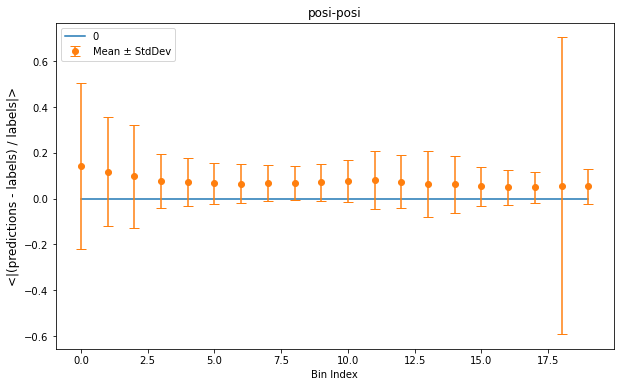

In [12]:
plot_AAPD(all_predictions1, all_labels1, 'posi-posi')

In [27]:
print(evaluation.calculate_aapd(all_predictions1, all_labels1))

0.07333846390247345


In [32]:
percent_acc = []
sigma_1 = []
sigma_2 = []
sigma_3 = []
n = all_predictions1.shape[0]
all_predictions1 = all_predictions1.detach().cpu().numpy()
all_labels1 = all_labels1.detach().cpu().numpy()
for i in range(n):
    percent_acc_i = all_predictions1[i] / all_labels1[i]
    mu_i = np.mean(percent_acc_i)
    sigma_i = np.std(percent_acc_i)
    percent_acc.append(mu_i)
    sigma_1.append([mu_i - sigma_i, mu_i + sigma_i])
    sigma_2.append([mu_i - 2 * sigma_i, mu_i + 2 * sigma_i])
    sigma_3.append([mu_i - 3 * sigma_i, mu_i + 3 * sigma_i])

In [37]:
percent_acc = all_predictions1 / all_labels1
percent_acc.shape

(19588, 20)

In [38]:
mu = np.mean(percent_acc, axis=0)
mu.shape

(20,)

In [39]:
std = np.std(percent_acc, axis=0)
std.shape

(20,)

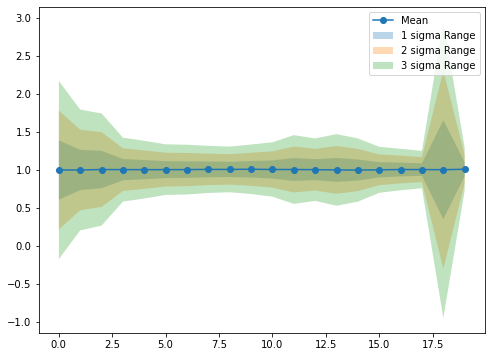

In [42]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(20), mu, label='Mean', marker='o')

for i in range(1, 4):
    lower_bound = mu - i * std
    upper_bound = mu + i * std
    plt.fill_between(range(len(mu)), lower_bound, upper_bound, alpha=0.3, label=f'{i} sigma Range')
    
plt.legend(loc = 'upper right')
plt.show()

In [46]:
print(np.min(percent_acc), np.max(percent_acc))
print(mu)

-87.83895 21.500826
[0.99426746 0.99506515 1.0008376  0.9996104  0.9992528  0.99950725
 0.9999391  1.0027531  1.0024506  1.0044028  1.0014714  1.0010271
 0.9991804  0.99559313 0.99427766 0.99711    1.000947   1.000329
 0.998349   1.0046579 ]


In [48]:
for i in range(20):
    print(f'{i} min = {np.min(percent_acc[:, i])}, max = {np.max(percent_acc[:, i])}')

0 min = -12.748624801635742, max = 21.500825881958008
1 min = -12.706639289855957, max = 7.965542793273926
2 min = -11.28604507446289, max = 12.782031059265137
3 min = 0.2970808148384094, max = 5.412478446960449
4 min = 0.28744831681251526, max = 3.922823667526245
5 min = 0.3136711120605469, max = 5.85621452331543
6 min = 0.45979049801826477, max = 5.37495756149292
7 min = 0.46299758553504944, max = 3.395103693008423
8 min = 0.3700259327888489, max = 2.855465888977051
9 min = 0.27471259236335754, max = 3.8019509315490723
10 min = 0.16354696452617645, max = 2.7281157970428467
11 min = 0.18619666993618011, max = 9.482120513916016
12 min = 0.17010118067264557, max = 5.923967361450195
13 min = 0.18888786435127258, max = 16.7188777923584
14 min = -8.805312156677246, max = 6.82473087310791
15 min = 0.2621627748012543, max = 4.3984270095825195
16 min = 0.31611549854278564, max = 6.599092483520508
17 min = 0.4613986313343048, max = 2.597942352294922
18 min = -87.83895111083984, max = 11.927371

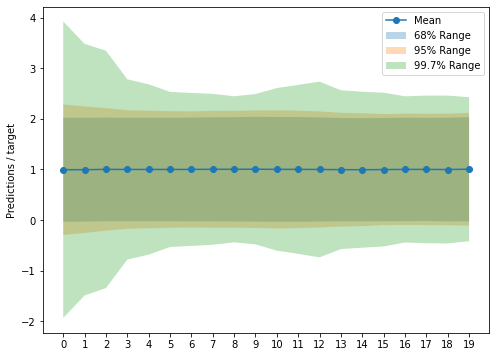

In [9]:
plot_percent_acc(all_predictions1, all_labels1)

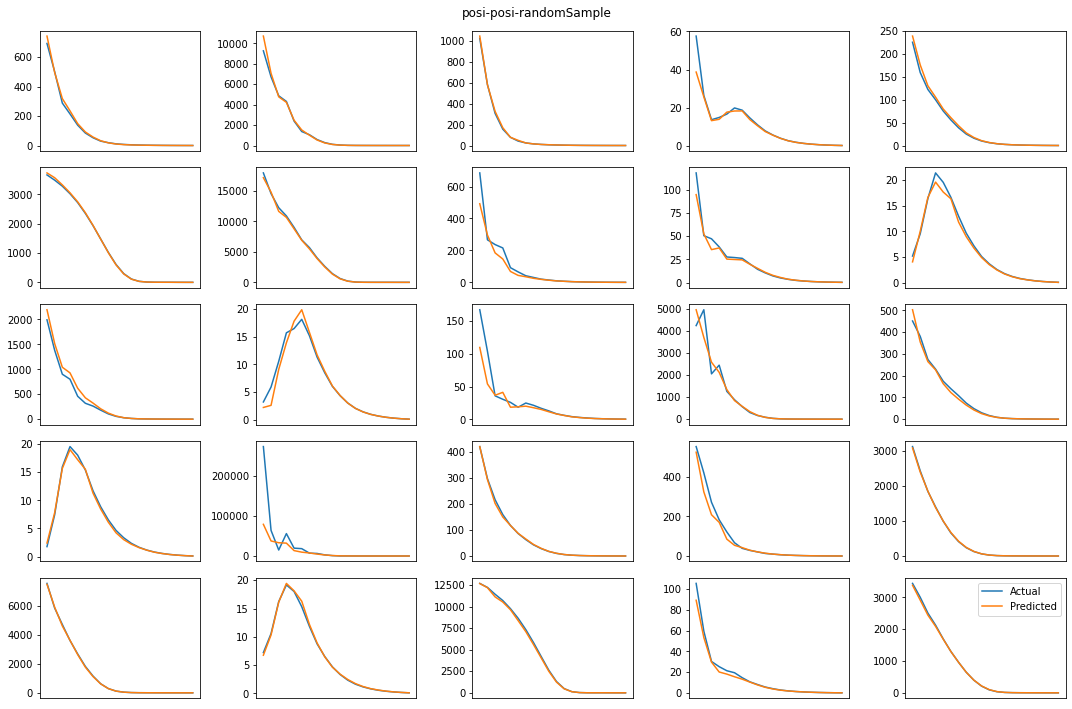

In [9]:
evaluation.plot_55(all_predictions1, all_labels1, "posi-posi-randomSample")

In [11]:
all_predictions1t, all_labels1t = evaluation.pred_lab(best_model_ASPD_1, train_dataloader, target_idx=1)

In [12]:
print(evaluation.calculate_aapd(all_predictions1t, all_labels1t))

0.07349450886249542


In [13]:
test_int = np.load('x_test.npy').astype(np.float32)
test_out = np.load('y_test.npy').astype(np.float32)

test_out1 = test_out[:, 0, :]
test_out2 = test_out[:, 1, :]
test_out3 = test_out[:, 2, :]

test_dataset = MultiTaskDataset.MultiTaskDataset(test_int, test_out1, test_out2, test_out3)
test_dataloader = DataLoader(test_dataset)

In [14]:
all_predictions1_test, all_labels1_test = evaluation.pred_lab(best_model_ASPD_1, test_dataloader, target_idx=1)
print(evaluation.calculate_aapd(all_predictions1_test, all_labels1_test))

0.08160141855478287


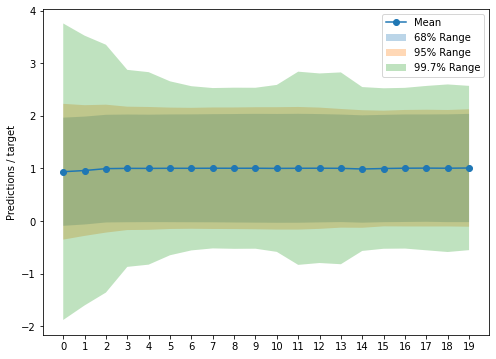

In [15]:
plot_percent_acc(all_predictions1_test, all_labels1_test)

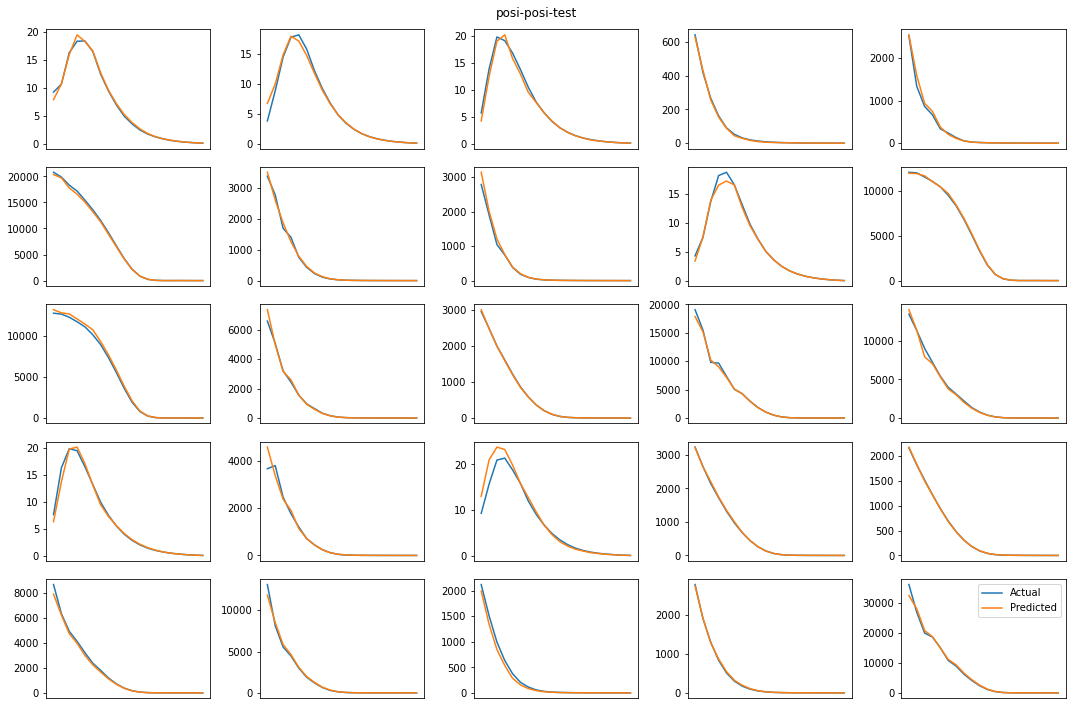

In [16]:
evaluation.plot_55(all_predictions1_test, all_labels1_test, "posi-posi-test")

In [18]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
pearson_vals, spearman_vals = [], []
for i in range(all_labels1_test.shape[0]):
    pearson_vals.append(pearsonr(all_labels1_test[i], all_predictions1_test[i])[0] if pearsonr(all_labels1_test[i], all_predictions1_test[i])[1] < 0.05 else None)
    spearman_vals.append(spearmanr(all_labels1_test[i], all_predictions1_test[i])[0] if spearmanr(all_labels1_test[i], all_predictions1_test[i])[1] < 0.05 else None)
pearson_vals = [x for x in pearson_vals if x is not None]
spearman_vals = [x for x in spearman_vals if x is not None]

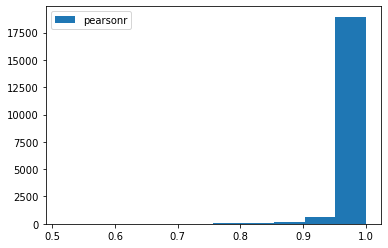

In [22]:
plt.hist(pearson_vals, label = 'pearsonr')
plt.legend(loc = 'upper left')

In [39]:
best_model_ASPD_2 = IAModel256(input_dimension=train_int.shape[1], output_dimension=train_out1.shape[1])
best_model_ASPD_2.load_state_dict(torch.load('best_model_ASPD_2.pth', map_location=torch.device('mps')))
best_model_ASPD_2.eval()
all_predictions2, all_labels2 = evaluation.pred_lab(best_model_ASPD_2, dev_dataloader, target_idx=2)

In [40]:
print(evaluation.calculate_aapd(all_predictions2, all_labels2))

1.0116066932678223


In [41]:
best_model_ASPD_3 = IAModel256(input_dimension=train_int.shape[1], output_dimension=train_out1.shape[1])
best_model_ASPD_3.load_state_dict(torch.load('best_model_ASPD_3.pth', map_location=torch.device('mps')))
best_model_ASPD_3.eval()
all_predictions3, all_labels3 = evaluation.pred_lab(best_model_ASPD_3, dev_dataloader, target_idx=3)

In [42]:
print(evaluation.calculate_aapd(all_predictions3, all_labels3))

1.1152881383895874


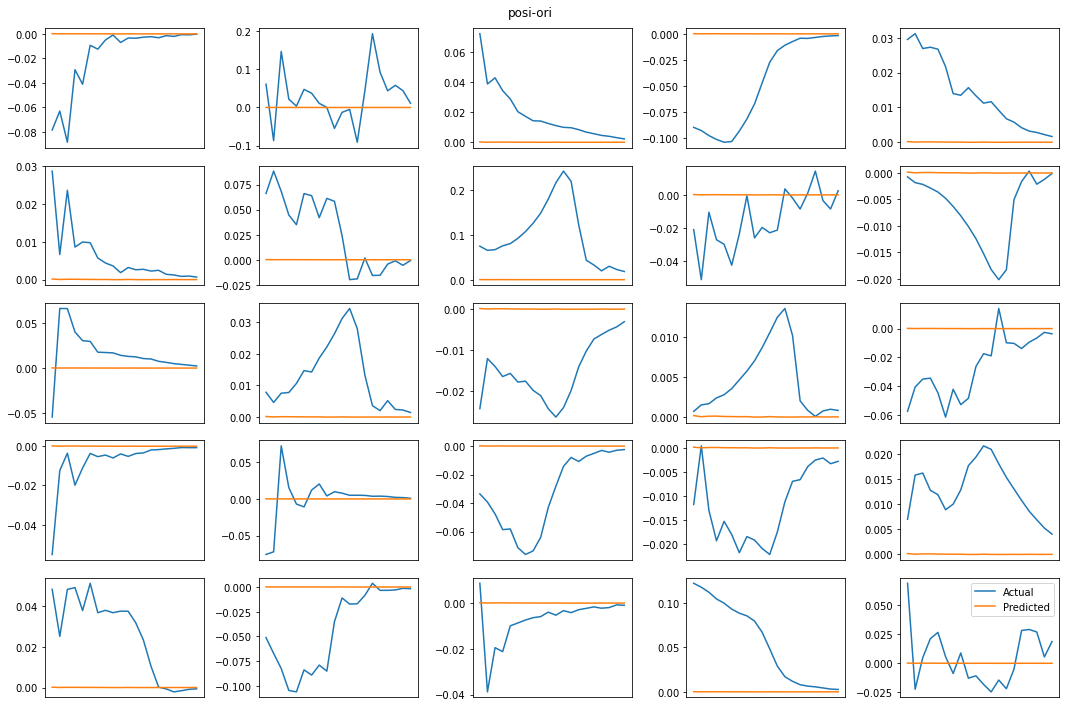

In [19]:
evaluation.plot_55(all_predictions2, all_labels2, "posi-ori")

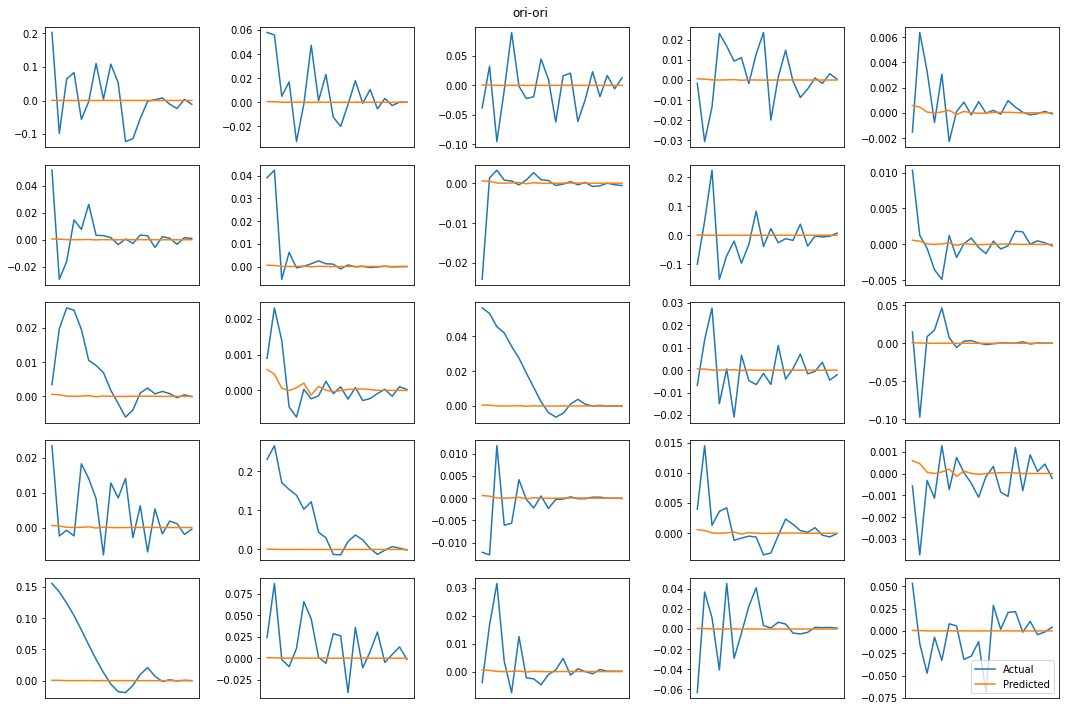

In [20]:
evaluation.plot_55(all_predictions3, all_labels3, "ori-ori")

rmse for position-position correlation: [6.2861812e+03 3.3282576e+03 1.9714744e+03 1.5739630e+03 7.3905627e+02
 3.5709320e+02 2.6603363e+02 1.4370081e+02 8.5086304e+01 4.9550961e+01
 3.1450243e+01 1.5980809e+01 6.4560080e+00 1.9209551e+00 6.2021834e-01
 3.4630623e-01 3.7224066e-01 1.4081348e-01 9.1525830e-02 6.2197726e-02]
rmse for position-orientation correlation: [0.08190338 0.07603446 0.07180008 0.06702001 0.06261781 0.06295241
 0.05921256 0.05705883 0.05638153 0.05815065 0.06074637 0.06123586
 0.05572991 0.04365793 0.02314327 0.01609733 0.01307144 0.01284329
 0.00945309 0.00813459]
rmse for orientation-orientation correlation: [0.08741498 0.07958975 0.06723721 0.0519366  0.04414801 0.03577812
 0.0282281  0.02156734 0.01935458 0.01914967 0.0215752  0.02307324
 0.02187603 0.01959094 0.01674127 0.01337798 0.00865061 0.00804732
 0.00622604 0.00456343]


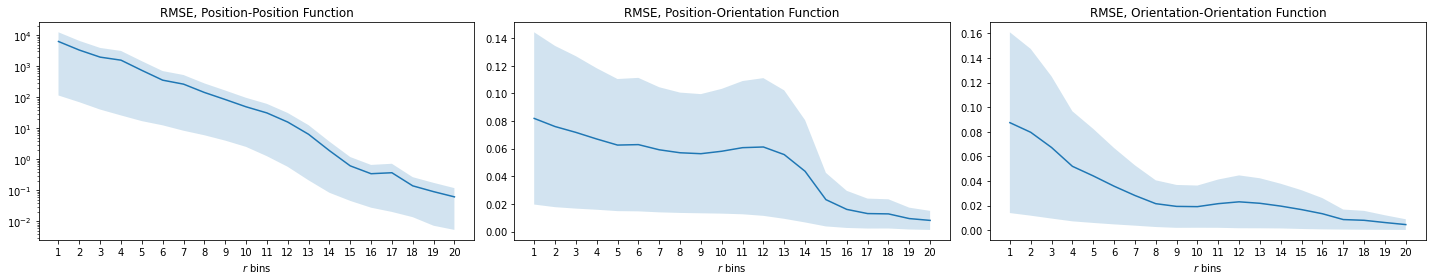

In [21]:
evaluation.plot_RMSE(all_predictions1, all_labels1, all_predictions2, all_labels2, all_predictions3, all_labels3)

## AAPD

In [43]:
best_model_AAPD_1 = IAModel256(input_dimension=train_int.shape[1], output_dimension=train_out1.shape[1])
best_model_AAPD_1.load_state_dict(torch.load('best_model_AAPD_1.pth', map_location=torch.device('mps')))
best_model_AAPD_1.eval()
all_predictions1, all_labels1 = evaluation.pred_lab(best_model_AAPD_1, dev_dataloader, target_idx=1)

In [44]:
print(evaluation.calculate_aapd(all_predictions1, all_labels1))

0.20400170981884003


In [45]:
best_model_AAPD_2 = IAModel256(input_dimension=train_int.shape[1], output_dimension=train_out1.shape[1])
best_model_AAPD_2.load_state_dict(torch.load('best_model_AAPD_2.pth', map_location=torch.device('mps')))
best_model_AAPD_2.eval()
all_predictions2, all_labels2 = evaluation.pred_lab(best_model_AAPD_2, dev_dataloader, target_idx=2)

In [46]:
print(evaluation.calculate_aapd(all_predictions2, all_labels2))

1.1386698484420776


In [47]:
best_model_AAPD_3 = IAModel256(input_dimension=train_int.shape[1], output_dimension=train_out1.shape[1])
best_model_AAPD_3.load_state_dict(torch.load('best_model_AAPD_3.pth', map_location=torch.device('mps')))
best_model_AAPD_3.eval()
all_predictions3, all_labels3 = evaluation.pred_lab(best_model_AAPD_3, dev_dataloader, target_idx=3)

In [48]:
print(evaluation.calculate_aapd(all_predictions3, all_labels3))

1.05879807472229


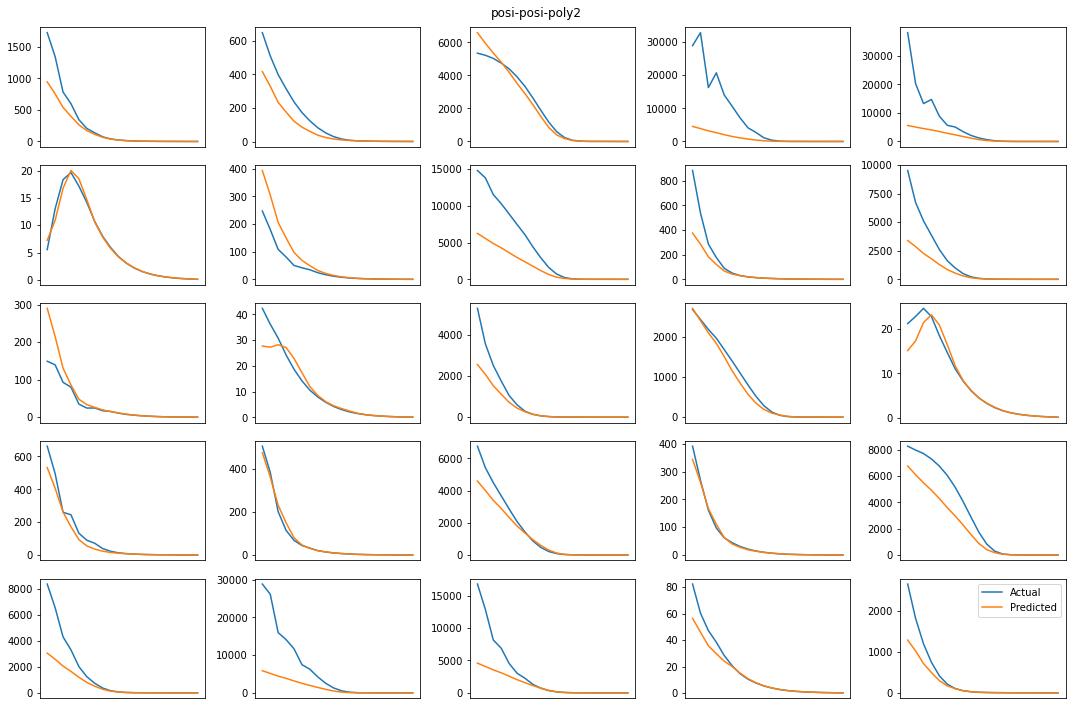

In [25]:
evaluation.plot_55(all_predictions1, all_labels1, "posi-posi-poly2")

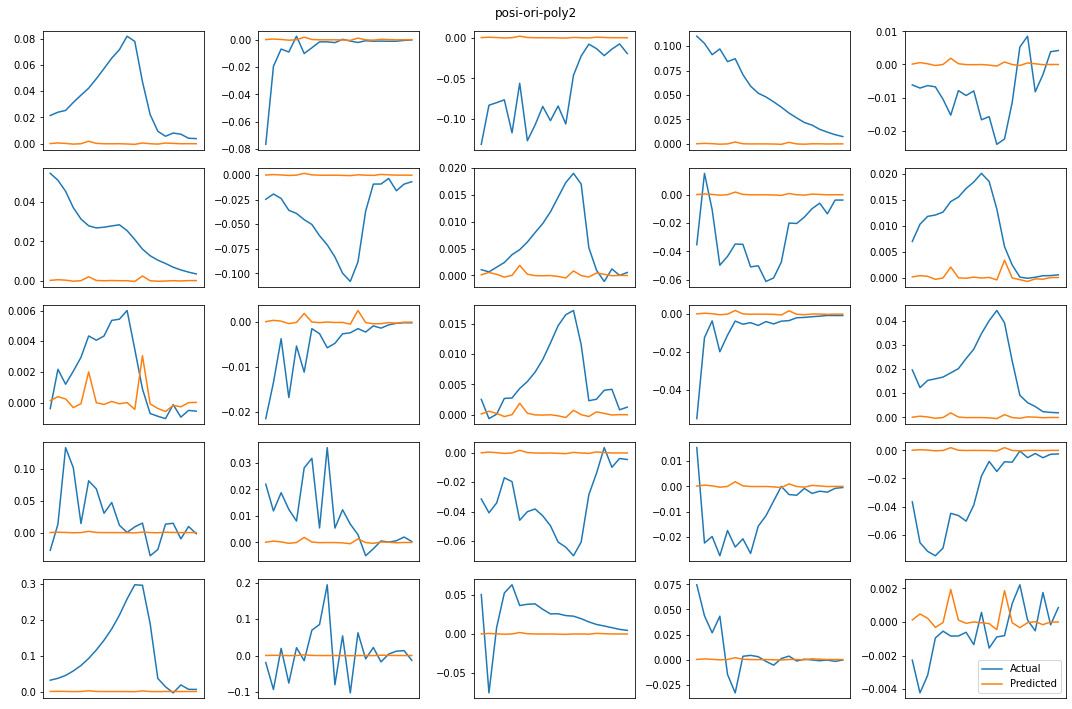

In [26]:
evaluation.plot_55(all_predictions2, all_labels2, "posi-ori-poly2")

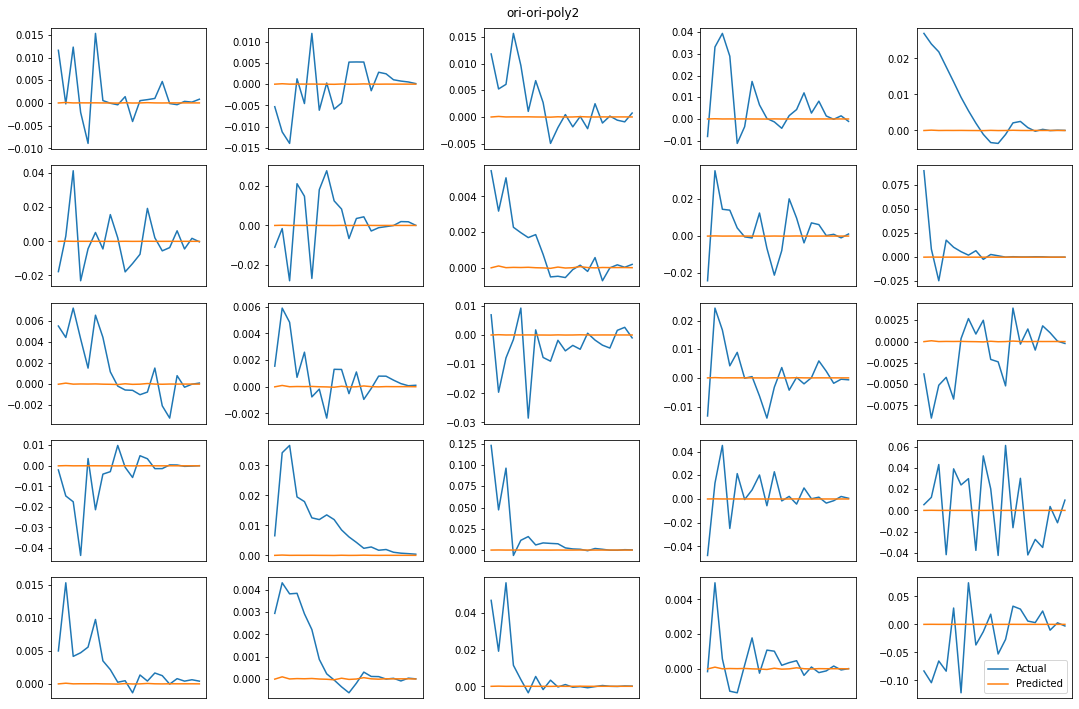

In [27]:
evaluation.plot_55(all_predictions3, all_labels3, "ori-ori-poly2")

rmse for position-position correlation: [1.3842905e+04 8.1029888e+03 5.4510879e+03 5.1296025e+03 2.7973708e+03
 1.8977875e+03 1.5731071e+03 1.0692074e+03 7.1425140e+02 4.4351910e+02
 2.3316742e+02 9.1819519e+01 2.6415958e+01 5.2304811e+00 5.8828008e-01
 3.8428393e-01 8.7913793e-01 2.3325250e-01 9.2768714e-02 7.5282939e-02]
rmse for position-orientation correlation: [0.08191447 0.07594211 0.07178677 0.06709137 0.06262316 0.06269491
 0.05916493 0.05706882 0.056396   0.05815002 0.06078914 0.06130343
 0.05579752 0.04365178 0.02317701 0.0159816  0.01302188 0.0128361
 0.00945418 0.00814218]
rmse for orientation-orientation correlation: [0.08754909 0.07967919 0.06725287 0.05193278 0.04416352 0.03582213
 0.02820112 0.0215877  0.01935657 0.01915172 0.02157468 0.02307414
 0.02187383 0.01959549 0.01674281 0.01337799 0.00865058 0.00804726
 0.00622604 0.00456351]


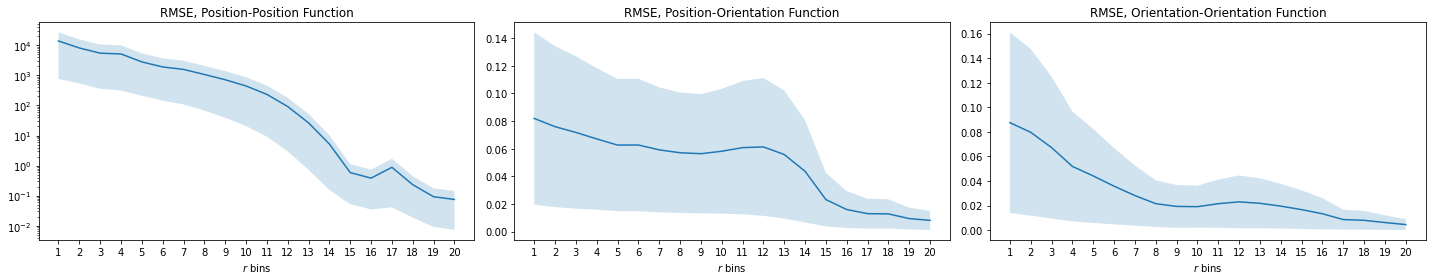

In [28]:
evaluation.plot_RMSE(all_predictions1, all_labels1, all_predictions2, all_labels2, all_predictions3, all_labels3)

## MSE

In [49]:
best_model_MSE_1 = IAModel256(input_dimension=train_int.shape[1], output_dimension=train_out1.shape[1])
best_model_MSE_1.load_state_dict(torch.load('best_model_MSE_1.pth', map_location=torch.device('mps')))
best_model_MSE_1.eval()
all_predictions1, all_labels1 = evaluation.pred_lab(best_model_MSE_1, dev_dataloader, target_idx=1)

In [50]:
print(evaluation.calculate_aapd(all_predictions1, all_labels1))

0.5259946584701538


In [51]:
best_model_MSE_2 = IAModel256(input_dimension=train_int.shape[1], output_dimension=train_out2.shape[1])
best_model_MSE_2.load_state_dict(torch.load('best_model_MSE_2.pth', map_location=torch.device('mps')))
best_model_MSE_2.eval()
all_predictions2, all_labels2 = evaluation.pred_lab(best_model_MSE_2, dev_dataloader, target_idx=2)

In [52]:
print(evaluation.calculate_aapd(all_predictions2, all_labels2))

2.7366256713867188


In [53]:
best_model_MSE_3 = IAModel256(input_dimension=train_int.shape[1], output_dimension=train_out3.shape[1])
best_model_MSE_3.load_state_dict(torch.load('best_model_MSE_3.pth', map_location=torch.device('mps')))
best_model_MSE_3.eval()
all_predictions3, all_labels3 = evaluation.pred_lab(best_model_MSE_3, dev_dataloader, target_idx=3)

In [54]:
print(evaluation.calculate_aapd(all_predictions3, all_labels3))

9.96716594696045


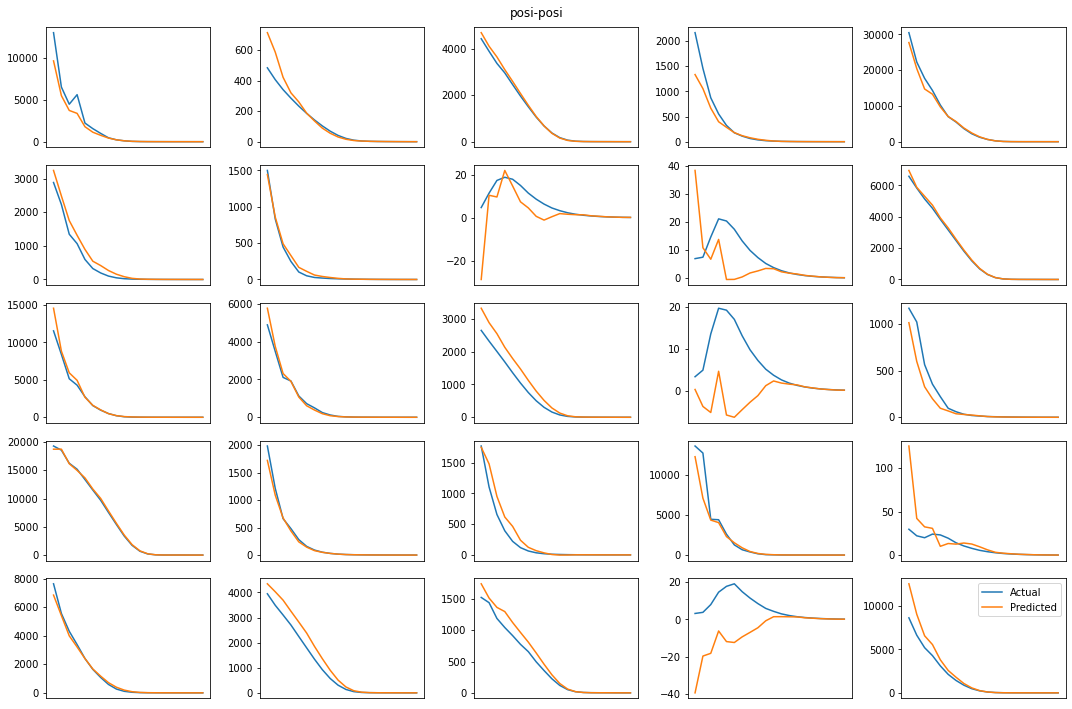

In [56]:
evaluation.plot_55(all_predictions1, all_labels1, "posi-posi")

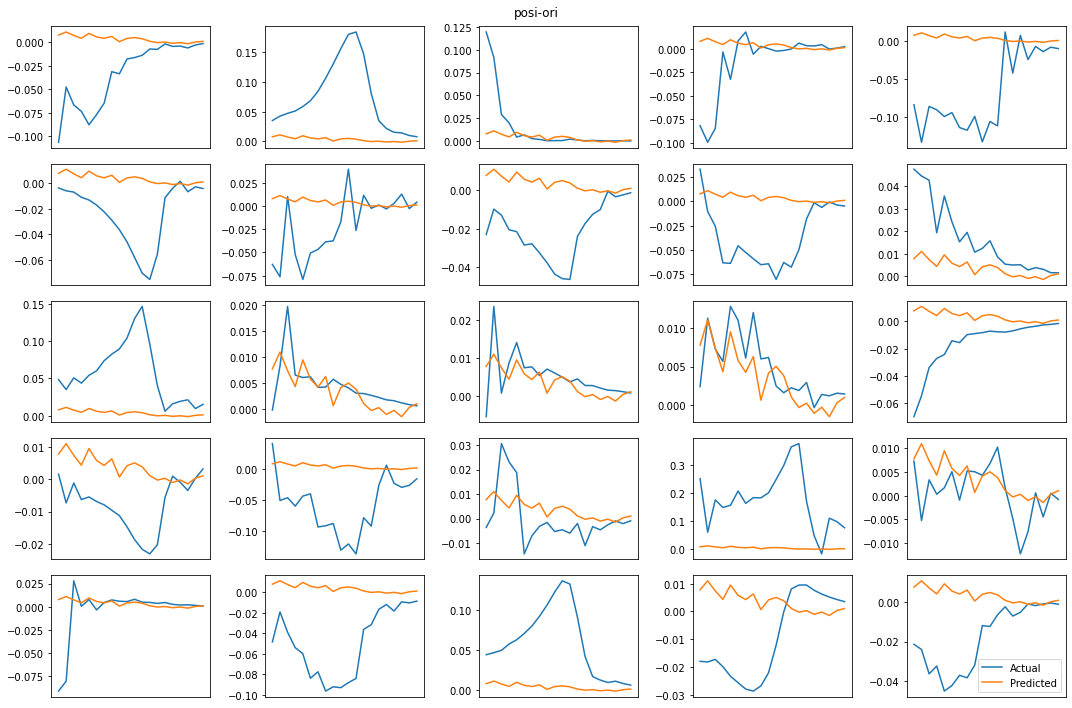

In [33]:
evaluation.plot_55(all_predictions2, all_labels2, "posi-ori")

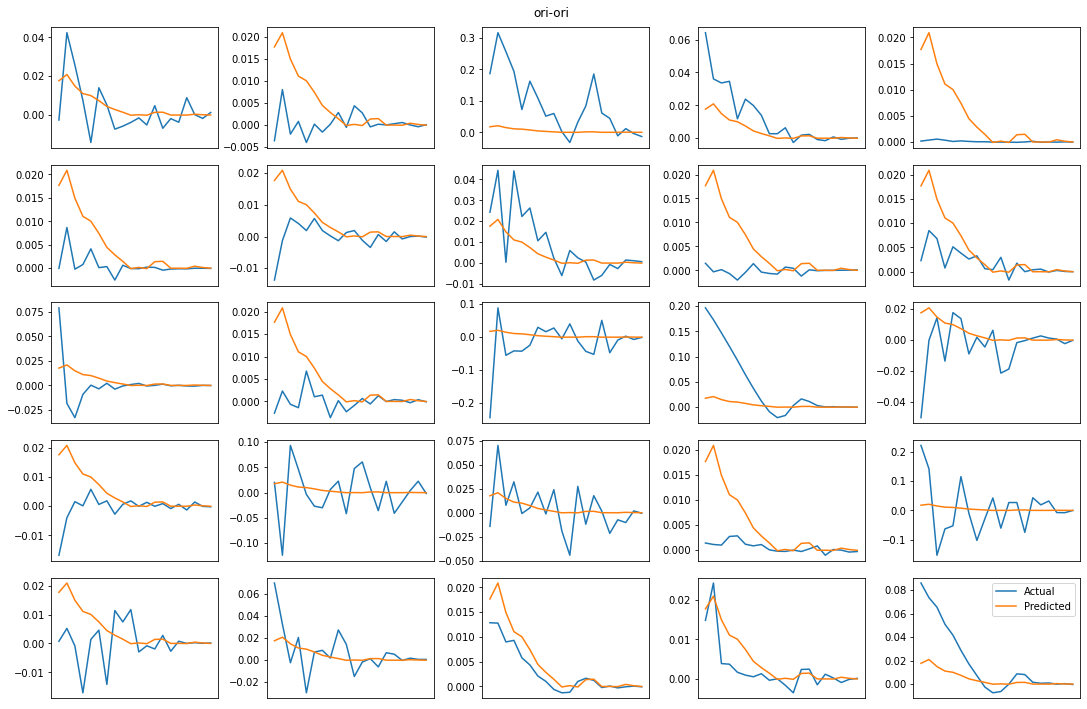

In [34]:
evaluation.plot_55(all_predictions3, all_labels3, "ori-ori")

rmse for position-position correlation: [6.3601675e+03 3.5006980e+03 2.1867412e+03 1.8869153e+03 1.0543409e+03
 6.7941980e+02 5.4142841e+02 3.7807544e+02 2.4441304e+02 1.4749570e+02
 7.3885117e+01 2.9772459e+01 9.3148804e+00 2.4641004e+00 6.7570287e-01
 4.3537322e-01 5.1354444e-01 2.4557747e-01 1.2265560e-01 8.0261439e-02]
rmse for position-orientation correlation: [0.08109805 0.07511652 0.07107802 0.06646956 0.0618368  0.06229707
 0.058685   0.05643716 0.05627886 0.05768894 0.06026181 0.06083969
 0.05560481 0.04369    0.023115   0.01624628 0.01310315 0.01311675
 0.00941929 0.00807452]
rmse for orientation-orientation correlation: [0.08528914 0.07713543 0.06517895 0.05018171 0.04289831 0.03480666
 0.02759482 0.02131457 0.0193508  0.01914823 0.02158039 0.02307679
 0.02177558 0.01948527 0.0167423  0.01337798 0.00865155 0.00804884
 0.00622608 0.00456352]


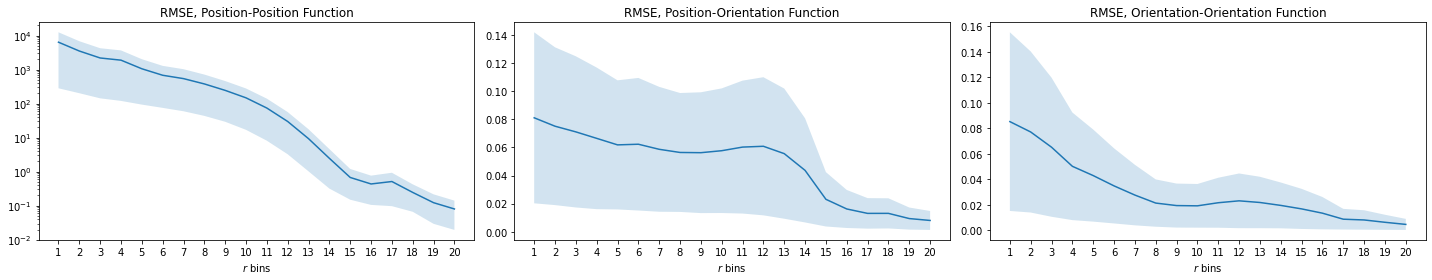

In [57]:
evaluation.plot_RMSE(all_predictions1, all_labels1, all_predictions2, all_labels2, all_predictions3, all_labels3)

In [55]:
class IAModelLeakyReLU(nn.Module):
    def __init__(self, input_dimension=7, output_dimension=20):
        super(IAModelLeakyReLU, self).__init__()
        
        self.input_dimension = input_dimension
        self.output_dimension = output_dimension
        
        self.network = nn.Sequential(
            nn.Linear(input_dimension, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, output_dimension)
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [59]:
best_model_Leaky_1 = IAModelLeakyReLU(input_dimension=train_int.shape[1], output_dimension=train_out1.shape[1])
best_model_Leaky_1.load_state_dict(torch.load('best_model_Leaky_1.pth', map_location=torch.device('mps')))
best_model_Leaky_1.eval()
all_predictions1, all_labels1 = evaluation.pred_lab(best_model_Leaky_1, dev_dataloader, target_idx=1)

In [66]:
print(evaluation.calculate_aapd(all_predictions1, all_labels1))

0.6612906455993652


In [60]:
best_model_Leaky_2 = IAModelLeakyReLU(input_dimension=train_int.shape[1], output_dimension=train_out2.shape[1])
best_model_Leaky_2.load_state_dict(torch.load('best_model_Leaky_2.pth', map_location=torch.device('mps')))
best_model_Leaky_2.eval()
all_predictions2, all_labels2 = evaluation.pred_lab(best_model_Leaky_2, dev_dataloader, target_idx=2)

In [67]:
print(evaluation.calculate_aapd(all_predictions2, all_labels2))

72.48374938964844


In [61]:
best_model_Leaky_3 = IAModelLeakyReLU(input_dimension=train_int.shape[1], output_dimension=train_out3.shape[1])
best_model_Leaky_3.load_state_dict(torch.load('best_model_Leaky_3.pth', map_location=torch.device('mps')))
best_model_Leaky_3.eval()
all_predictions3, all_labels3 = evaluation.pred_lab(best_model_Leaky_3, dev_dataloader, target_idx=3)

In [68]:
print(evaluation.calculate_aapd(all_predictions3, all_labels3))

2920.37841796875


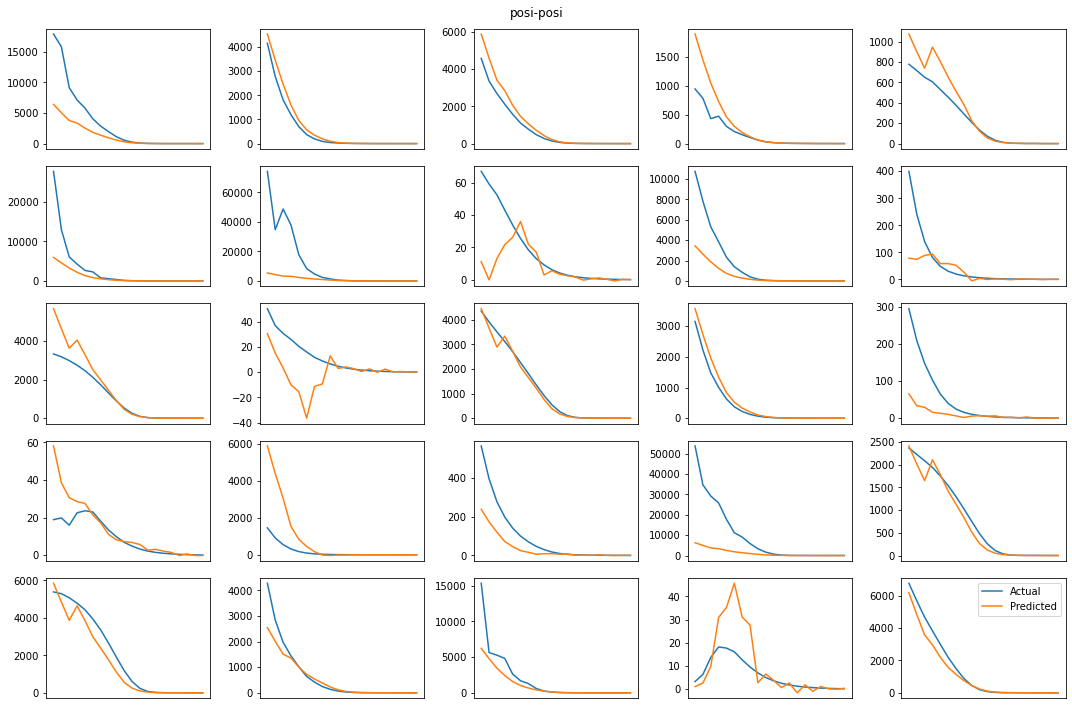

In [62]:
evaluation.plot_55(all_predictions1, all_labels1, "posi-posi")

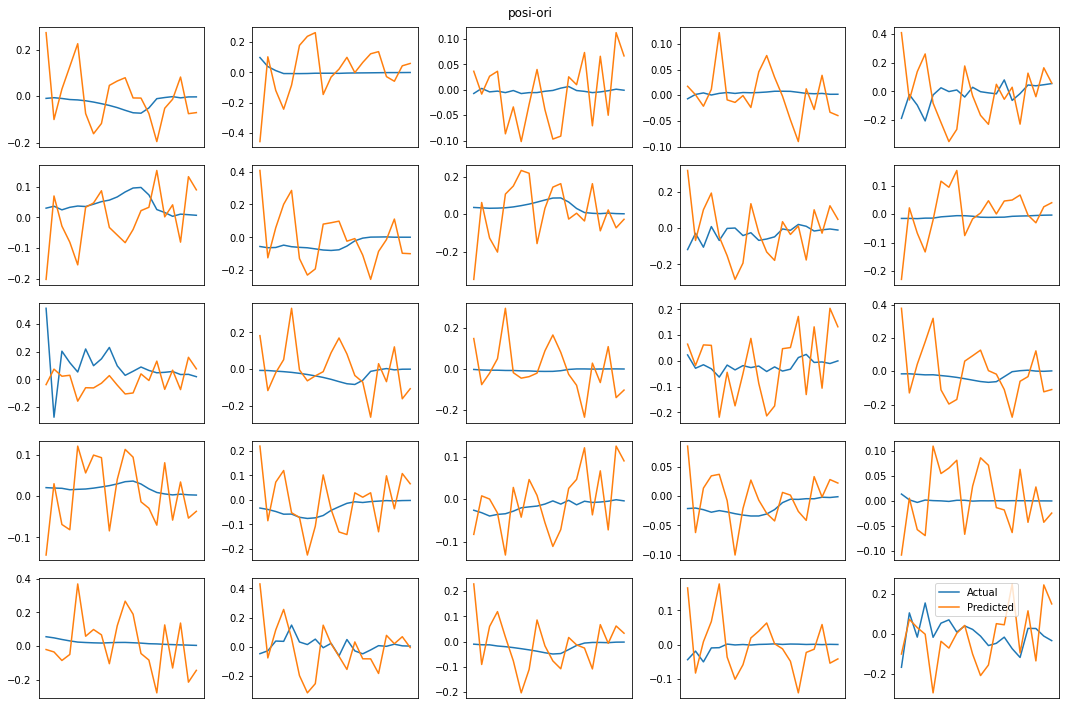

In [63]:
evaluation.plot_55(all_predictions2, all_labels2, "posi-ori")

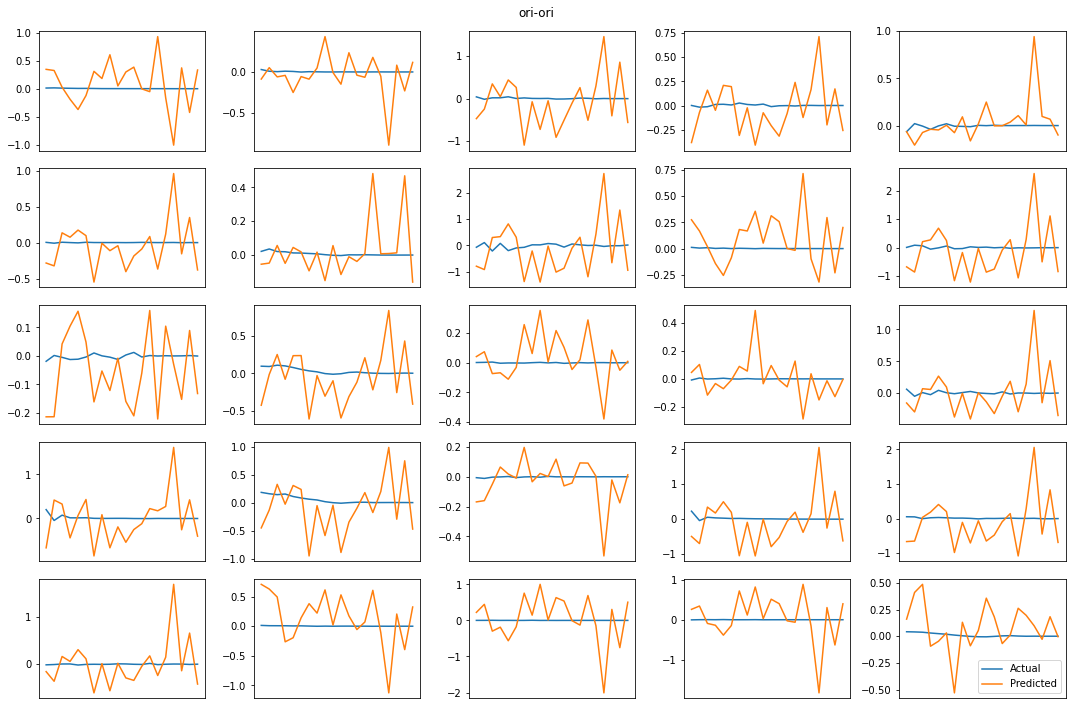

In [64]:
evaluation.plot_55(all_predictions3, all_labels3, "ori-ori")

rmse for position-position correlation: [1.36620020e+04 8.11019775e+03 5.63912549e+03 5.20462256e+03
 2.94865967e+03 2.08711548e+03 1.74820630e+03 1.22113000e+03
 8.34313782e+02 5.22265625e+02 2.70752655e+02 1.09091194e+02
 3.12977161e+01 6.23686361e+00 1.02103043e+00 1.41193986e+00
 1.34043777e+00 5.93540311e-01 5.51095068e-01 2.74726212e-01]
rmse for position-orientation correlation: [0.28439328 0.07528096 0.10985809 0.1636253  0.19672813 0.08979006
 0.1328869  0.11228777 0.11338028 0.09134861 0.13139138 0.10491525
 0.05786555 0.06368797 0.15019673 0.08689544 0.06515047 0.07729308
 0.11690331 0.07974932]
rmse for orientation-orientation correlation: [1.8641869  2.2307417  1.4256968  2.0865731  1.8098814  0.3174608
 0.7077537  0.85977393 0.680391   1.4626203  0.50558805 0.49209064
 1.0147177  0.19679514 0.6146786  0.6969795  1.2759756  0.31350046
 0.5722537  0.4460662 ]


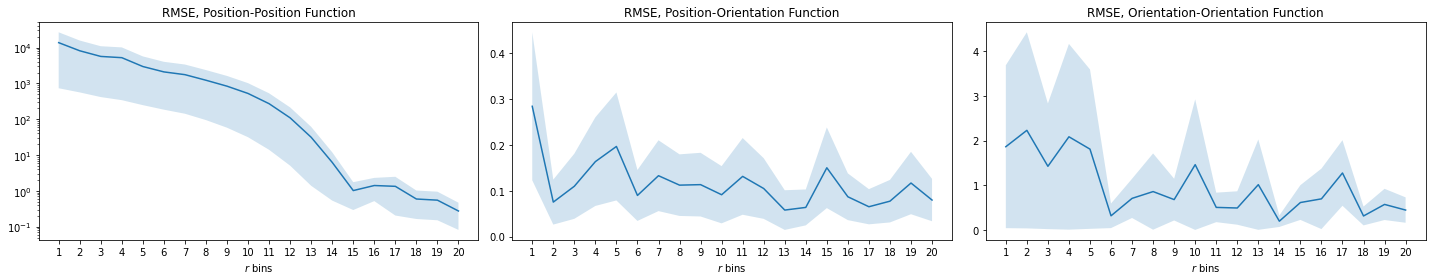

In [65]:
evaluation.plot_RMSE(all_predictions1, all_labels1, all_predictions2, all_labels2, all_predictions3, all_labels3)

## MSE Leaky

In [69]:
best_model_MSE_Leaky_1 = IAModelLeakyReLU(input_dimension=train_int.shape[1], output_dimension=train_out1.shape[1])
best_model_MSE_Leaky_1.load_state_dict(torch.load('best_model_MSE_Leaky_1.pth', map_location=torch.device('mps')))
best_model_MSE_Leaky_1.eval()
all_predictions1, all_labels1 = evaluation.pred_lab(best_model_MSE_Leaky_1, dev_dataloader, target_idx=1)

In [72]:
print(evaluation.calculate_aapd(all_predictions1, all_labels1))

3.5801188945770264


In [70]:
best_model_MSE_Leaky_2 = IAModelLeakyReLU(input_dimension=train_int.shape[1], output_dimension=train_out2.shape[1])
best_model_MSE_Leaky_2.load_state_dict(torch.load('best_model_MSE_Leaky_2.pth', map_location=torch.device('mps')))
best_model_MSE_Leaky_2.eval()
all_predictions2, all_labels2 = evaluation.pred_lab(best_model_MSE_Leaky_2, dev_dataloader, target_idx=2)

In [73]:
print(evaluation.calculate_aapd(all_predictions2, all_labels2))

18.726354598999023


In [71]:
best_model_MSE_Leaky_3 = IAModelLeakyReLU(input_dimension=train_int.shape[1], output_dimension=train_out3.shape[1])
best_model_MSE_Leaky_3.load_state_dict(torch.load('best_model_MSE_Leaky_3.pth', map_location=torch.device('mps')))
best_model_MSE_Leaky_3.eval()
all_predictions3, all_labels3 = evaluation.pred_lab(best_model_MSE_Leaky_3, dev_dataloader, target_idx=3)

In [74]:
print(evaluation.calculate_aapd(all_predictions3, all_labels3))

157.97447204589844


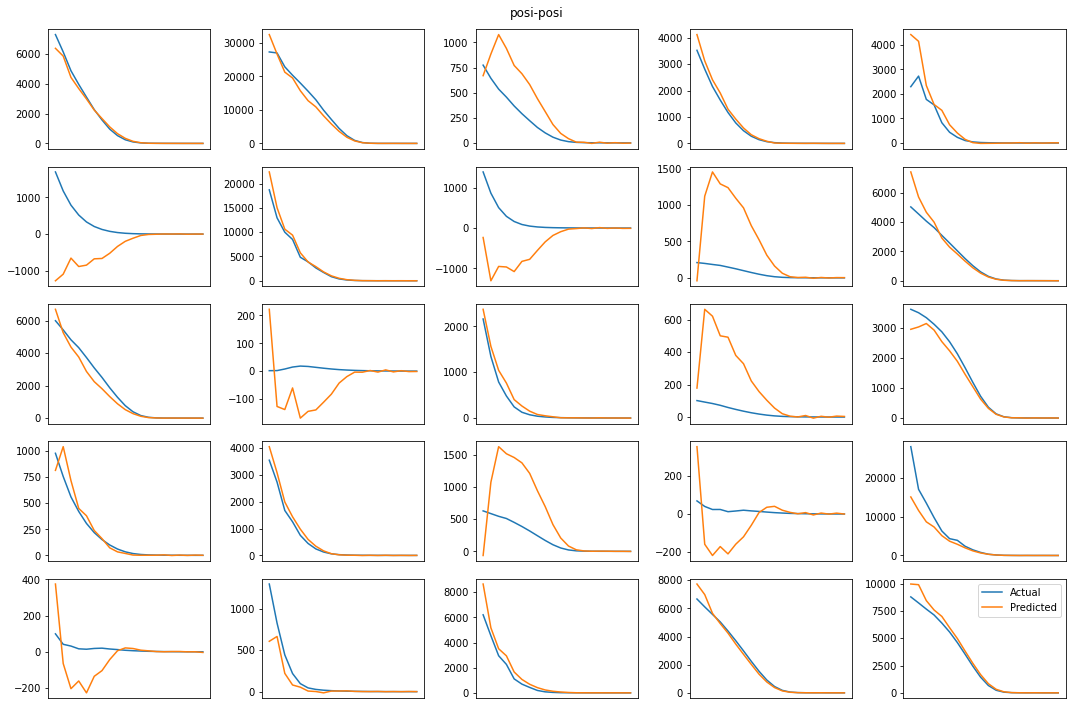

In [75]:
evaluation.plot_55(all_predictions1, all_labels1, "posi-posi")

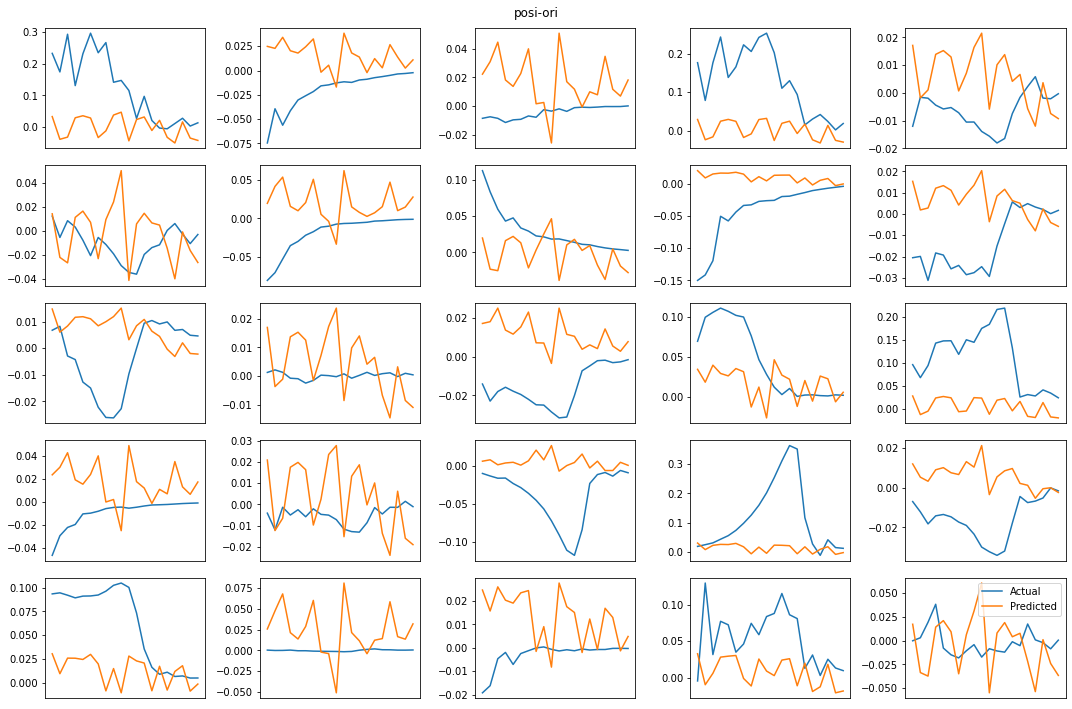

In [76]:
evaluation.plot_55(all_predictions2, all_labels2, "posi-ori")

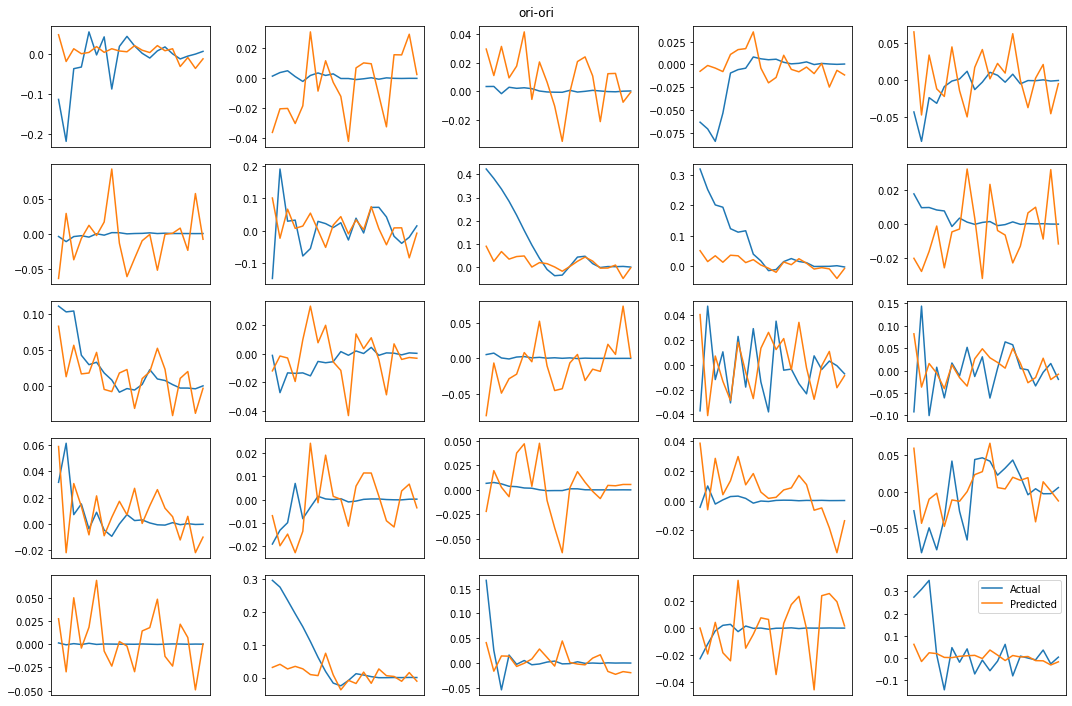

In [77]:
evaluation.plot_55(all_predictions3, all_labels3, "ori-ori")

rmse for position-position correlation: [6.3320269e+03 3.3690806e+03 2.1932229e+03 1.8489447e+03 9.8815350e+02
 6.4331262e+02 5.3916461e+02 4.0481784e+02 2.9801050e+02 1.9578416e+02
 1.1171495e+02 1.2518584e+02 2.5704418e+01 9.9974510e+01 2.1208385e+01
 1.0911859e+01 5.7162318e+00 8.5446075e+01 7.6770622e+01 3.7692135e+01]
rmse for position-orientation correlation: [0.07728153 0.08137692 0.07591864 0.06222156 0.05804785 0.05773848
 0.06485838 0.06338686 0.05410059 0.06899019 0.06754743 0.0574891
 0.0532246  0.04748137 0.02315836 0.02333964 0.03498392 0.01495073
 0.01896368 0.02293356]
rmse for orientation-orientation correlation: [0.09102514 0.08438441 0.06534168 0.05245245 0.04404779 0.04296726
 0.02907171 0.03776434 0.02221217 0.03027338 0.03714593 0.0271219
 0.02357337 0.03558562 0.02266332 0.02413091 0.01761967 0.01641495
 0.03322758 0.01002926]


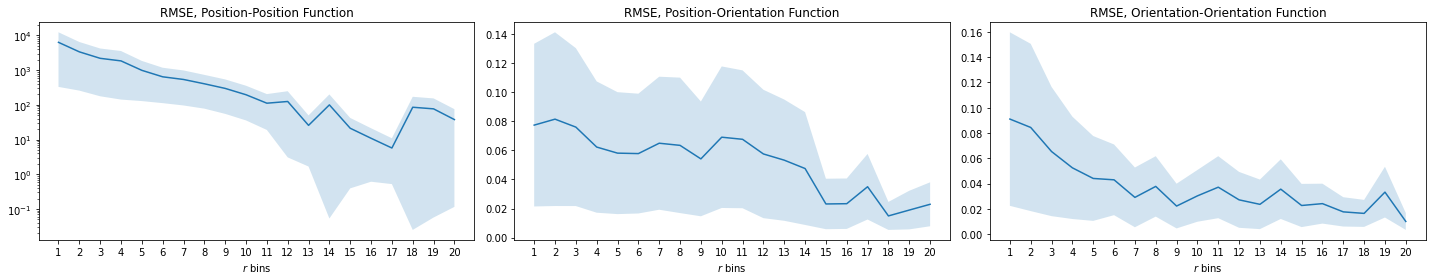

In [78]:
evaluation.plot_RMSE(all_predictions1, all_labels1, all_predictions2, all_labels2, all_predictions3, all_labels3)

In [79]:
model_MSE_Leaky_1 = IAModelLeakyReLU(input_dimension=train_int.shape[1], output_dimension=train_out1.shape[1])
model_MSE_Leaky_1.load_state_dict(torch.load('model_MSE_Leaky_1.pth', map_location=torch.device('mps')))
model_MSE_Leaky_1.eval()
all_predictions1, all_labels1 = evaluation.pred_lab(model_MSE_Leaky_1, dev_dataloader, target_idx=1)

In [82]:
print(evaluation.calculate_aapd(all_predictions1, all_labels1))

3.9403462409973145


In [80]:
model_MSE_Leaky_2 = IAModelLeakyReLU(input_dimension=train_int.shape[1], output_dimension=train_out2.shape[1])
model_MSE_Leaky_2.load_state_dict(torch.load('model_MSE_Leaky_2.pth', map_location=torch.device('mps')))
model_MSE_Leaky_2.eval()
all_predictions2, all_labels2 = evaluation.pred_lab(model_MSE_Leaky_2, dev_dataloader, target_idx=2)

In [83]:
print(evaluation.calculate_aapd(all_predictions2, all_labels2))

83.2704849243164


In [81]:
model_MSE_Leaky_3 = IAModelLeakyReLU(input_dimension=train_int.shape[1], output_dimension=train_out3.shape[1])
model_MSE_Leaky_3.load_state_dict(torch.load('model_MSE_Leaky_3.pth', map_location=torch.device('mps')))
model_MSE_Leaky_3.eval()
all_predictions3, all_labels3 = evaluation.pred_lab(model_MSE_Leaky_3, dev_dataloader, target_idx=3)

In [84]:
print(evaluation.calculate_aapd(all_predictions3, all_labels3))

173.005615234375


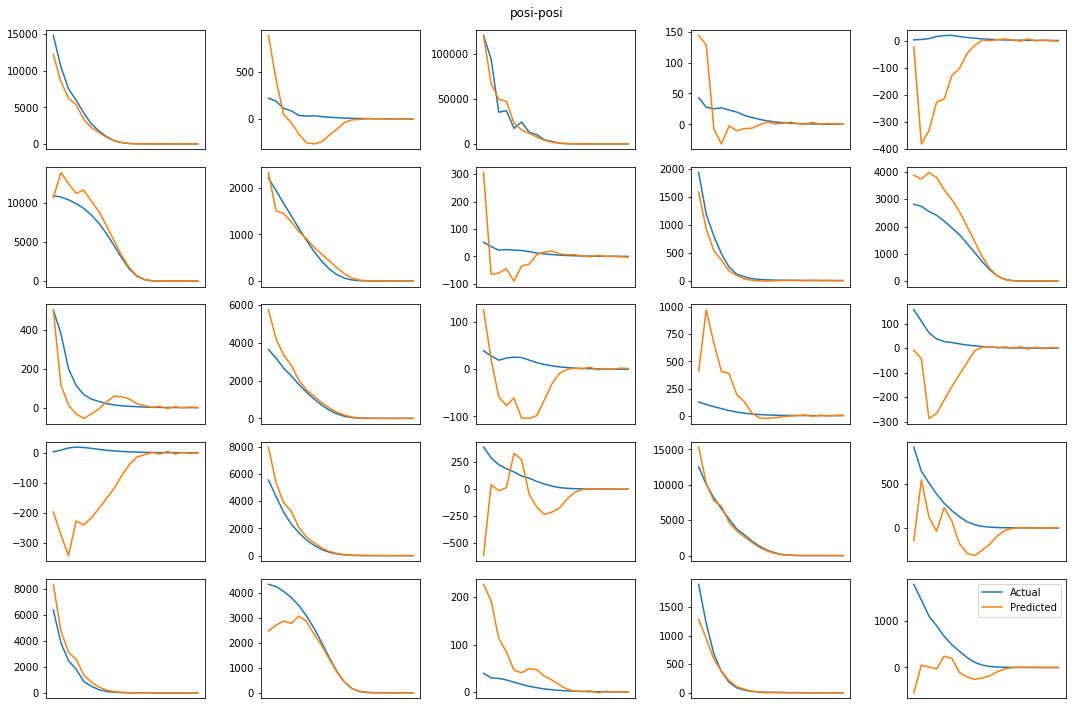

In [86]:
evaluation.plot_55(all_predictions1, all_labels1, "posi-posi")

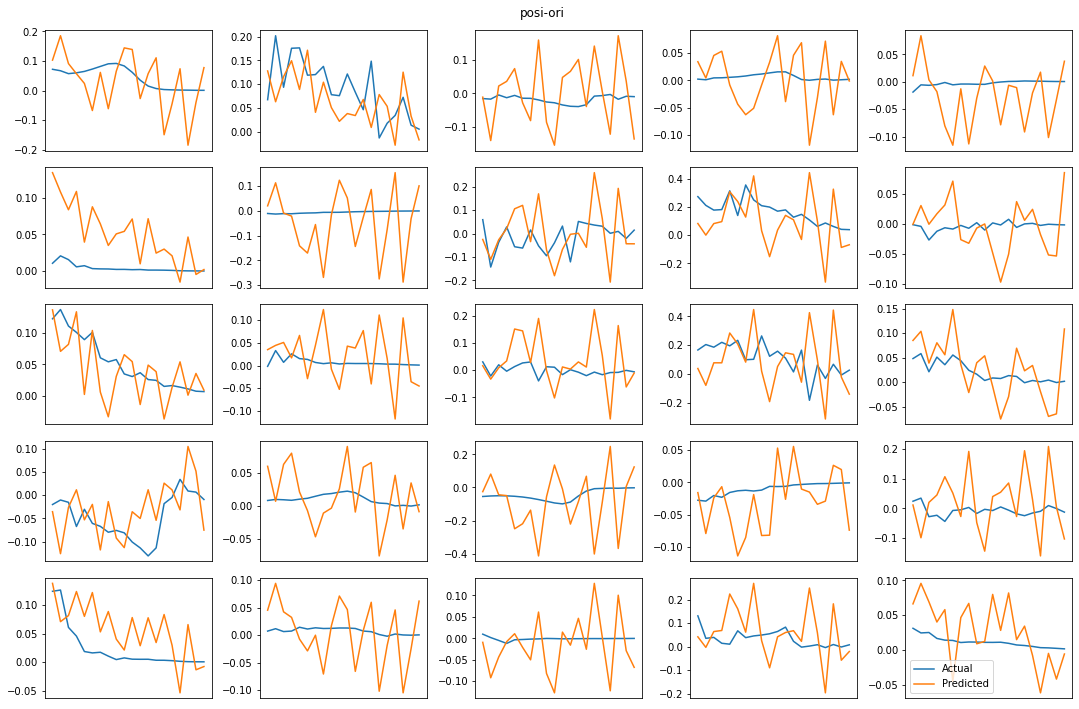

In [87]:
evaluation.plot_55(all_predictions2, all_labels2, "posi-ori")

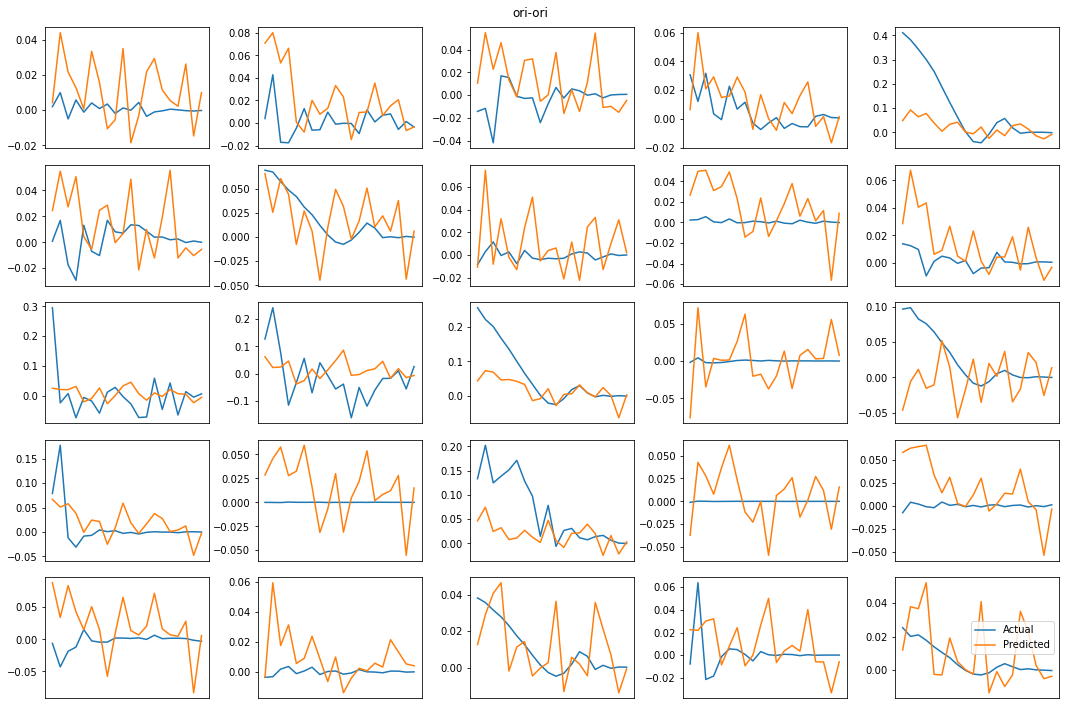

In [88]:
evaluation.plot_55(all_predictions3, all_labels3, "ori-ori")

rmse for position-position correlation: [6.3236846e+03 3.3651257e+03 2.1863777e+03 1.8421906e+03 9.8632513e+02
 6.4054047e+02 5.3837091e+02 4.0444366e+02 2.9884213e+02 1.9569456e+02
 1.1176608e+02 1.3158643e+02 2.6276388e+01 1.0580546e+02 2.2534611e+01
 1.1144436e+01 5.5171628e+00 9.0200722e+01 8.1286667e+01 4.0193493e+01]
rmse for position-orientation correlation: [0.06855621 0.1031424  0.05808727 0.05538701 0.11025676 0.08473421
 0.05584457 0.15883906 0.0599204  0.11307514 0.05829766 0.09550502
 0.07127717 0.06371249 0.17169732 0.04449126 0.12735625 0.16928032
 0.04709553 0.0816447 ]
rmse for orientation-orientation correlation: [0.09078273 0.08034608 0.06585827 0.05265118 0.04413074 0.0387003
 0.03251757 0.03722883 0.02175644 0.0387056  0.03789617 0.02653638
 0.02368721 0.0317319  0.02443171 0.02700194 0.01898903 0.01873741
 0.03299194 0.00839759]


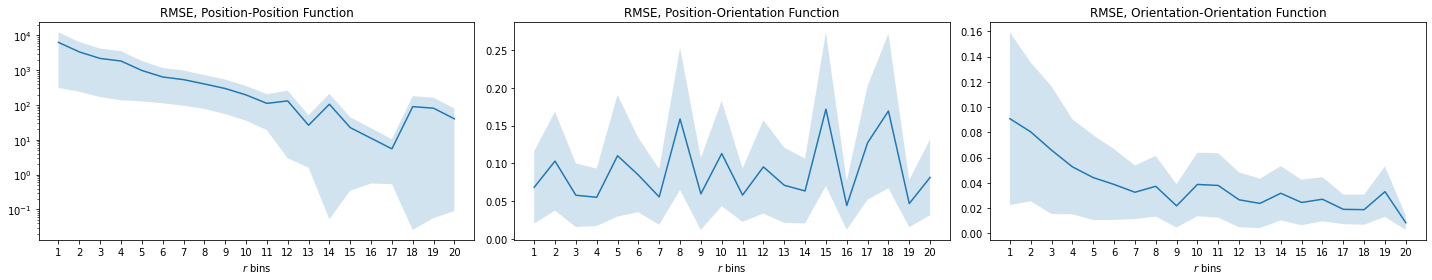

In [89]:
evaluation.plot_RMSE(all_predictions1, all_labels1, all_predictions2, all_labels2, all_predictions3, all_labels3)

In [111]:
best_model_AAPD_Leaky_1 = IAModelLeakyReLU(input_dimension=train_int.shape[1], output_dimension=train_out1.shape[1])
best_model_AAPD_Leaky_1.load_state_dict(torch.load('best_model_AAPD_Leaky_1.pth', map_location=torch.device('mps')))
best_model_AAPD_Leaky_1.eval()
all_predictions1, all_labels1 = evaluation.pred_lab(best_model_AAPD_Leaky_1, dev_dataloader, target_idx=1)

In [114]:
print(evaluation.calculate_aapd(all_predictions1, all_labels1))

0.3250267207622528


In [112]:
best_model_AAPD_Leaky_2 = IAModelLeakyReLU(input_dimension=train_int.shape[1], output_dimension=train_out2.shape[1])
best_model_AAPD_Leaky_2.load_state_dict(torch.load('best_model_AAPD_Leaky_2.pth', map_location=torch.device('mps')))
best_model_AAPD_Leaky_2.eval()
all_predictions2, all_labels2 = evaluation.pred_lab(best_model_AAPD_Leaky_2, dev_dataloader, target_idx=2)

In [115]:
print(evaluation.calculate_aapd(all_predictions2, all_labels2))

545.0103149414062


In [113]:
best_model_AAPD_Leaky_3 = IAModelLeakyReLU(input_dimension=train_int.shape[1], output_dimension=train_out3.shape[1])
best_model_AAPD_Leaky_3.load_state_dict(torch.load('best_model_AAPD_Leaky_3.pth', map_location=torch.device('mps')))
best_model_AAPD_Leaky_3.eval()
all_predictions3, all_labels3 = evaluation.pred_lab(best_model_AAPD_Leaky_3, dev_dataloader, target_idx=3)

In [116]:
print(evaluation.calculate_aapd(all_predictions3, all_labels3))

2006.8974609375


In [118]:
class linearencoderdecoder(nn.Module):
    def __init__(self, input_dim: int = 7, hidden_dim: int = 128, bottleneck_dim = 64, output_dim: int = 20):
        super(linearencoderdecoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, bottleneck_dim),
            nn.BatchNorm1d(bottleneck_dim),
            nn.ReLU(),
            nn.Linear(bottleneck_dim, bottleneck_dim),
            nn.BatchNorm1d(bottleneck_dim),
            nn.ReLU(),
            nn.Linear(bottleneck_dim, output_dim)
        )
        
    def forward(self, x):
        # Encoding
        x = self.encoder(x)
        # Decoding
        x = self.decoder(x)
        return x

In [119]:
best_model_ED_AAPD_1 = linearencoderdecoder()
best_model_ED_AAPD_1.load_state_dict(torch.load('best_model_ED_AAPD_1.pth', map_location=torch.device('mps')))
best_model_ED_AAPD_1.eval()
all_predictions1, all_labels1 = evaluation.pred_lab(best_model_ED_AAPD_1, dev_dataloader, target_idx=1)

In [122]:
print(evaluation.calculate_aapd(all_predictions1, all_labels1))

0.5518190860748291


In [120]:
best_model_ED_AAPD_2 = linearencoderdecoder()
best_model_ED_AAPD_2.load_state_dict(torch.load('best_model_ED_AAPD_2.pth', map_location=torch.device('mps')))
best_model_ED_AAPD_2.eval()
all_predictions2, all_labels2 = evaluation.pred_lab(best_model_ED_AAPD_2, dev_dataloader, target_idx=2)

In [123]:
print(evaluation.calculate_aapd(all_predictions2, all_labels2))

3.1322689056396484


In [121]:
best_model_ED_AAPD_3 = linearencoderdecoder()
best_model_ED_AAPD_3.load_state_dict(torch.load('best_model_ED_AAPD_3.pth', map_location=torch.device('mps')))
best_model_ED_AAPD_3.eval()
all_predictions3, all_labels3 = evaluation.pred_lab(best_model_ED_AAPD_3, dev_dataloader, target_idx=3)

In [124]:
print(evaluation.calculate_aapd(all_predictions3, all_labels3))

1.1498785018920898


In [125]:
best_model_ED_ASPD_1 = linearencoderdecoder()
best_model_ED_ASPD_1.load_state_dict(torch.load('best_model_ED_ASPD_1.pth', map_location=torch.device('mps')))
best_model_ED_ASPD_1.eval()
all_predictions1, all_labels1 = evaluation.pred_lab(best_model_ED_ASPD_1, dev_dataloader, target_idx=1)

In [128]:
print(evaluation.calculate_aapd(all_predictions1, all_labels1))

0.10568863153457642


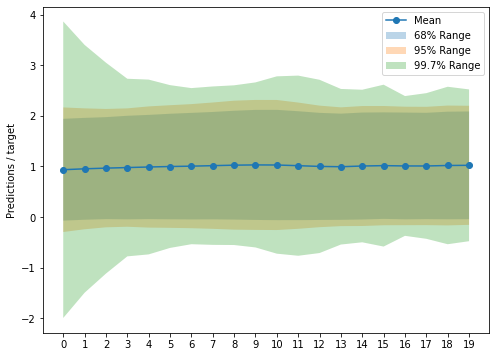

In [131]:
plot_percent_acc(all_predictions1, all_labels1)

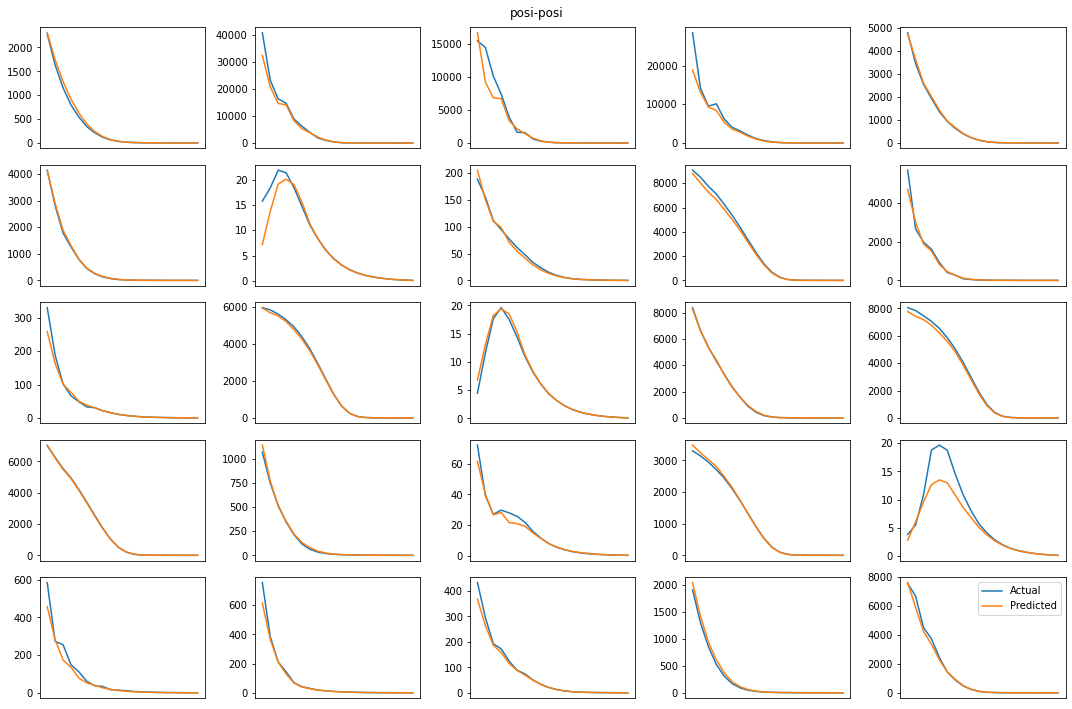

In [132]:
evaluation.plot_55(all_predictions1, all_labels1, "posi-posi")

In [126]:
best_model_ED_ASPD_2 = linearencoderdecoder()
best_model_ED_ASPD_2.load_state_dict(torch.load('best_model_ED_ASPD_2.pth', map_location=torch.device('mps')))
best_model_ED_ASPD_2.eval()
all_predictions2, all_labels2 = evaluation.pred_lab(best_model_ED_ASPD_2, dev_dataloader, target_idx=2)

In [129]:
print(evaluation.calculate_aapd(all_predictions2, all_labels2))

1.0566407442092896


In [127]:
best_model_ED_ASPD_3 = linearencoderdecoder()
best_model_ED_ASPD_3.load_state_dict(torch.load('best_model_ED_ASPD_3.pth', map_location=torch.device('mps')))
best_model_ED_ASPD_3.eval()
all_predictions3, all_labels3 = evaluation.pred_lab(best_model_ED_ASPD_3, dev_dataloader, target_idx=3)

In [130]:
print(evaluation.calculate_aapd(all_predictions3, all_labels3))

1.131508231163025
